- **TODO:** read image data
- **TODO:** check if pre-processing required
- **TODO:** implement class dataset (to input into data_loader)
- **TODO:** util function to fetch classes in each domain

In [1]:
import os
import sys
sys.path.append("../")
import numpy as np
import pandas as pd
from skimage import io
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets
from torch.utils.data.sampler import SubsetRandomSampler
from pathlib import Path
from PIL import Image

import warnings
warnings.filterwarnings("ignore")

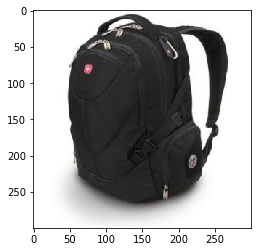

In [3]:
# utility functions
def office_dataset_paths(dataset):
    if os.path.exists("data"):
        print("three ")
        if dataset == "office/amazon":
            pass

def show_images(image):
    """Plot image from dataset"""
    plt.imshow(image)
    plt.pause(0.001)
    
plt.figure()

dataset = "office"
domain = "amazon"
image_class = "back_pack"
image_name = "frame_0001.jpg"

show_images(io.imread(os.path.join("data",dataset,
                                   domain,"images",
                                   image_class,image_name)))    

In [14]:
# main.py

# root_dir = "datasets/office/amazon/images"
path = "datasets/office/amazon"
image_dir = "/images"
img_size = 100

# Pytorch ImageFolder fits our dataset structure
# dataset = datasets.ImageFolder(root=root_dir, transform=data_transform)
image_data_folder = datasets.ImageFolder(root=path+image_dir)
print("total no. of images in amazon dataset:",len(image_data_folder))

data_transforms = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.RandomSizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

total no. of images in amazon dataset: 2817


In [15]:
# dataloader.py
class OfficeAmazonDataset(Dataset):
    """Class to create an iterable dataset 
    of images and corresponding labels """
        
    def __init__(self, image_folder_dataset, transform=None):
        super(OfficeAmazonDataset, self).__init__()
        self.image_folder_dataset = image_folder_dataset
        self.transform = transform

    def __len__(self):
        return len(self.image_folder_dataset.imgs)
    
    def __getitem__(self, idx):
        # read image, class from folder_dataset given index
        img, img_label = image_folder_dataset[idx][0], image_folder_dataset[idx][1]
        
        # apply transformations (it already returns them as torch tensors)
        if self.transform is not None:
            self.transform(img)
        
        img_label_pair = {"image": img,
                         "class": img_label}
        
        return img_label_pair

def get_dataloader(dataset, batch_size):
        
    def get_subset(indices, start, end):
        return indices[start:start + end]
    
    # Split train/val data ratios
    TRAIN_RATIO, VALIDATION_RATIO = 0.7, 0.3
    train_set_size = int(len(dataset) * TRAIN_RATIO)
    validation_set_size = int(len(dataset) * VALIDATION_RATIO)

    # Generate random indices for train and val sets
    indices = torch.randperm(len(dataset))
    train_indices = get_subset(indices, 0, train_set_size)
    validation_indices = get_subset(indices, train_set_size, validation_set_size)
    # test_indices = get_subset(indices, train_count + validation_count, len(dataset))

    # Create sampler objects 
    train_sampler = SubsetRandomSampler(train_indices)
    val_sampler = SubsetRandomSampler(validation_indices)

    # Create data loaders for data
    train_loader = DataLoader(dataset, batch_size=batch_size, 
                              sampler=train_sampler, num_workers=4)

    val_loader = DataLoader(dataset, batch_size=batch_size, 
                            sampler=val_sampler, num_workers=4)
    
    return train_loader, val_loader

In [19]:
amazon_dataset = OfficeAmazonDataset(image_folder_dataset=image_data_folder, transform=data_transforms)
train_loader, val_loader = get_dataloader(amazon_dataset, batch_size=4)